In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
input_path = "../input/392-crypto-currency-pairs-at-minute-resolution"

def load_data(symbol, source=input_path):
    path_name = source + "/" + symbol + ".csv"
    
    # Load data
    df = pd.read_csv(path_name, index_col='time')
    
    # Convert timestamp to datetime
    df.index = pd.to_datetime(df.index, unit='ms')
    
    # Remove duplicate indices if present
    df = df[~df.index.duplicated(keep='first')]
    
    # As mentioned in the description, bins without any change are not recorded.
    # We have to fill these gaps by filling them with the last value until a change occurs.
    df = df.resample('1T').ffill()
    df_day = df.resample('1D').ffill()
    return df,df_day

In [3]:
# Low lag trendline function
def cal_LLT(price: pd.Series, alpha: float):

    LLT = []
    price_value = price.values
    LLT.append(price_value[0])
    LLT.append(price_value[1])


    for i, e in enumerate(price_value):
        if i > 1:

            v = (alpha - alpha**2 / 4) * e + (alpha**2 / 2) * price_value[i - 1] - (
                alpha - 3 * (alpha**2) / 4) * price_value[i - 2] + 2 * (
                    1 - alpha) * LLT[i - 1] - (1 - alpha)**2 * LLT[i - 2]

            LLT.append(v)

    return LLT

In [4]:
def log_return(data):
    return np.log(data.shift(0) / data.shift(1))

1. Data Processing

In [5]:
btcusd,btcusd_day = load_data("btcusd")
ethusd,ethusd_day = load_data("ethusd")
#ltcusd,ltcusd_day = load_data("ltcusd")
#xrpusd,xrpusd_day = load_data("xrpusd")

# Take a look at the head of the BTC/USD data
btcusd.head()

,open,close,high,low,volume
time,,,,,
2013-04-01 00:07:00,93.25,93.30,93.30,93.25,93.300000
2013-04-01 00:08:00,100.00,100.00,100.00,100.00,93.300000
2013-04-01 00:09:00,93.30,93.30,93.30,93.30,33.676862
2013-04-01 00:10:00,93.30,93.30,93.30,93.30,33.676862
2013-04-01 00:11:00,93.35,93.47,93.47,93.35,20.000000


In [6]:
# define trading period starts from 2017
price_df = btcusd[['close']].copy()
price_df = price_df[price_df.index.year > 2016]

/tmp/ipykernel_20/1311241790.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_return(btcusd_day['close']), kde=False)


<Axes: xlabel='close'>

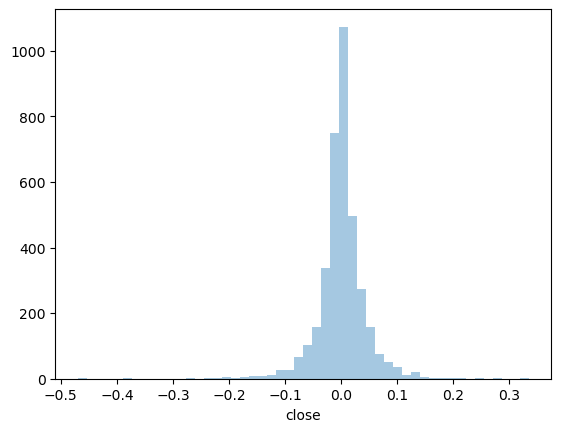

In [7]:
# Show the distribution of daily log return
sns.distplot(log_return(btcusd_day['close']), kde=False)

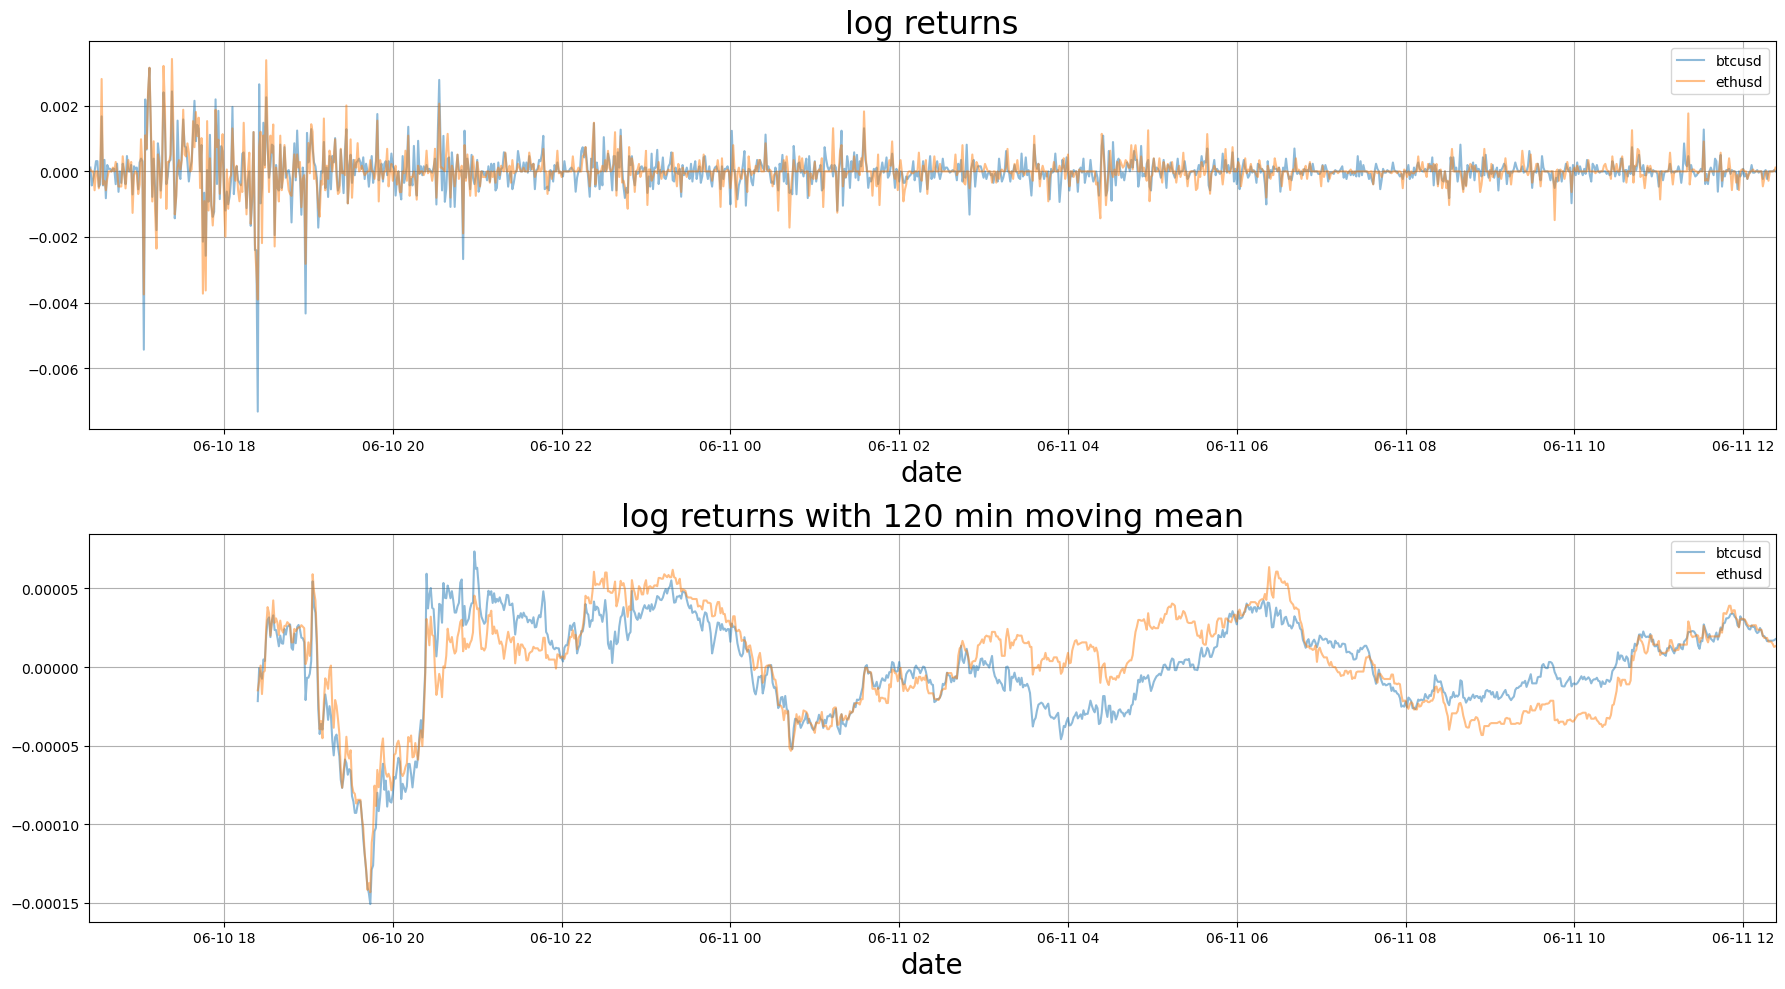

In [8]:
# Define the parameters for the moving mean
n_ticks = 1200
rolling_mean = 120

fig, ax = plt.subplots(2, 1, figsize=(18, 10))

ax[0].plot(log_return(btcusd['close'].iloc[-n_ticks:]), alpha=0.5, label='btcusd')
ax[0].plot(log_return(ethusd['close'].iloc[-n_ticks:]), alpha=0.5, label='ethusd')

ax[0].set_xlim([ethusd.index[-n_ticks], ethusd.index[-1]])
ax[0].set_title('log returns', fontsize=23)
ax[0].set_xlabel('date', fontsize=20)
ax[0].grid()
ax[0].legend()

ax[1].plot(log_return(btcusd['close'].iloc[-n_ticks:].rolling(rolling_mean).mean()), alpha=0.5, label='btcusd')
ax[1].plot(log_return(ethusd['close'].iloc[-n_ticks:].rolling(rolling_mean).mean()), alpha=0.5, label='ethusd')

ax[1].set_xlim([ethusd.index[-n_ticks], ethusd.index[-1]])
ax[1].set_title('log returns with {} min moving mean'.format(rolling_mean), fontsize=23)
ax[1].set_xlabel('date', fontsize=20)
ax[1].grid()
ax[1].legend()

fig.tight_layout()
plt.show()

2. Trenline Exploration

In [9]:
# MA Trendline
for i in [10,30,60,120]:
    price_df[f'MA%d'%i] = price_df['close'].rolling(i).mean()

# EMA Trendline
price_df['EMA'] = price_df['close'].ewm(alpha=0.05,adjust=False).mean()

# LLT Trendline
price_df['LLT'] = cal_LLT(price_df['close'],0.05)

<Axes: title={'center': 'Trendline comparison'}, xlabel='time'>

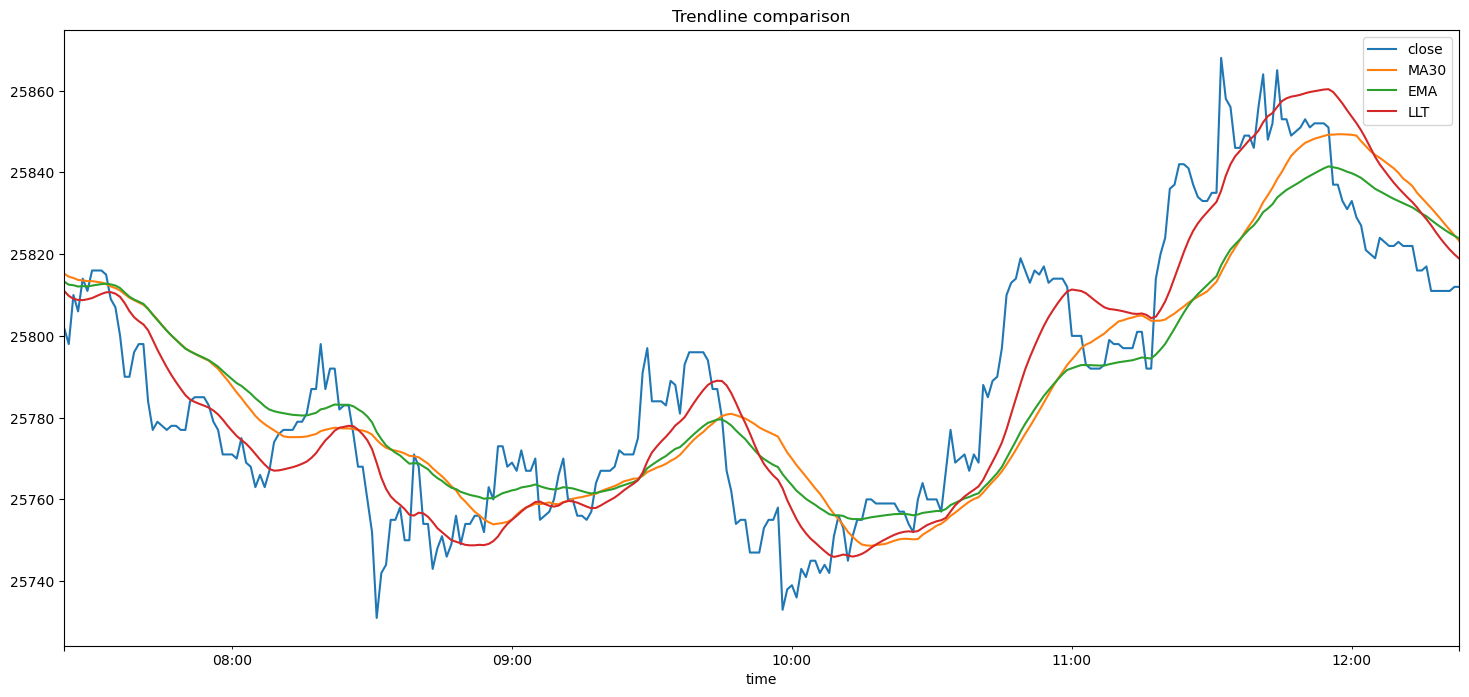

In [10]:
price_df[['close', 'MA30', 'EMA', 'LLT']].iloc[-300:].plot(figsize=(18,8),title='Trendline comparison')

In [11]:
# alpha
alpha_all = [2/(d+1) for d in range(2,50,10)]

for a in alpha_all:
    price_df[f'LLT(%0.5s)'%a] = cal_LLT(price_df['close'],a)

3. Backtesting

In [12]:
backtest = []
backtest.append(price_df['close'][0])
backtest.append(price_df['close'][1])
backtest.append(price_df['close'][2])

In [13]:
# Rule: Based on LLT slope
# if slope > 0, then buy
for i in range(2,len(price_df)-1):
    if price_df['LLT(0.666)'][i] > price_df['LLT(0.666)'][i-1]:
        backtest.append(backtest[i] + price_df['close'][i+1] - price_df['close'][i])
    else:
        backtest.append(backtest[i] - (price_df['close'][i+1] - price_df['close'][i]))

In [14]:
price_df['backtest'] = backtest
price_df['strategy_net'] = price_df['backtest'] / price_df['backtest'][0]
price_df['btcnet'] = price_df['close'] / price_df['close'][0]

<Axes: xlabel='time'>

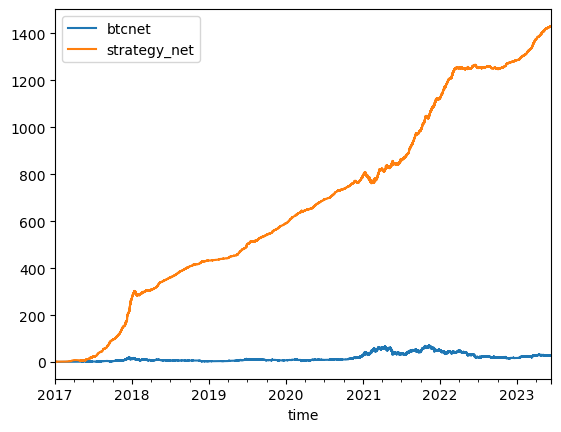

In [15]:
price_df[['btcnet', 'strategy_net']].plot()

In [16]:
price_df['peak'] = price_df['strategy_net'].cummax()
price_df['drawdown'] = price_df['strategy_net']-price_df['peak']

In [17]:
print('Maximum drawdown of the simulated trading result is %.0f%%.' % (price_df['drawdown'].min()*100/price_df['peak'].loc[price_df['drawdown'].idxmin()]))

print('Maximum drawdown occured on %s.' % price_df['drawdown'].idxmin().strftime("%d%b%y"))

Maximum drawdown of the simulated trading result is -6%.
Maximum drawdown occured on 08Feb21.
